<a href="https://colab.research.google.com/github/venom1204/Symbolic-Calculation-Project/blob/main/task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# task 1

In [1]:
!pip install sympy pandas tqdm numpy matplotlib seaborn wordcloud

In [2]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter
from sympy.parsing.mathematica import parse_mathematica
import random

In [3]:
# Configuration
SEED = 42
NUM_SAMPLES = 1000
MAX_DEPTH = 3
sp.init_printing()
sns.set(style="whitegrid", palette="muted")


In [4]:
np.random.seed(SEED)
sp.core.random.seed(SEED)

# Function Generation

In [5]:
def generate_random_function(depth=0):
    """Generate random mathematical functions with simplified category naming."""
    x = sp.symbols('x')
    basic_funcs = [
        (sp.sin, 'trigonometric'),
        (sp.cos, 'trigonometric'),
        (sp.exp, 'exponential'),
        (sp.log, 'logarithmic'),
        (lambda x: 1/(1 + x), 'rational'),
        (lambda x: x**sp.Integer(np.random.randint(1, 4)), 'polynomial')
    ]
    if depth >= MAX_DEPTH:
        return np.random.choice([x, sp.Integer(np.random.randint(1, 5))]), 'atomic'

    operation = np.random.choice(['function', 'add', 'mul', 'div', 'pow'])
    if operation == 'function':
        func, category = random.choice(basic_funcs)
        arg = generate_random_function(depth+1)[0]
        return func(arg), category
    elif operation == 'add':
        a, c1 = generate_random_function(depth+1)
        b, c2 = generate_random_function(depth+1)
        return a + b, 'composite'
    elif operation == 'mul':
        a, c1 = generate_random_function(depth+1)
        b, c2 = generate_random_function(depth+1)
        return a * b, 'composite'
    elif operation == 'div':
        num, c1 = generate_random_function(depth+1)
        den, c2 = generate_random_function(depth+1)
        return num / den, 'composite'
    elif operation == 'pow':
        base, c1 = generate_random_function(depth+1)
        exp = sp.Integer(np.random.randint(2, 5))
        return base**exp, 'composite'


# 2. Tokenization


In [6]:
def ast_tokenizer(expr):
    """Tokenize using SymPy's abstract syntax tree"""
    tokens = []
    for node in sp.preorder_traversal(expr):
        if node.is_Atom:
            tokens.append(str(node))
        else:
            tokens.append(node.func.__name__)
    return tokens

# 3. Dataset Processing

In [7]:
dataset = []
categories = []
mathematica_exprs = [
    "Sin[x]^2 + Cos[x]^3",
    "Exp[x]/(1 + x)",
    "Log[1 + x]^2",
    "Tanh[x]/(1 + x^2)"
]

In [8]:
# Generating SymPy functions
for _ in tqdm(range(NUM_SAMPLES), desc="Generating Functions"):
    try:
        func, category = generate_random_function()
        # Checking if the function is well-defined at x=0 before attempting series expansion
        if not func.subs(sp.Symbol('x'), 0).has(sp.nan, sp.oo, sp.zoo, sp.I):
            expansion = sp.series(func, sp.Symbol('x'), 0, 5).removeO()
            dataset.append({
                'source': 'SymPy',
                'function': str(func),
                'expansion': str(expansion),
                'category': category,
                'tokens': ast_tokenizer(func)
            })
            categories.append(category)
    except (NotImplementedError, ValueError, TypeError, AttributeError): # Added more exception types
        continue

Generating Functions: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]


In [9]:
# Process Mathematica expressions
for expr in tqdm(mathematica_exprs, desc="Processing Mathematica"):
    try:
        func = parse_mathematica(expr)
        expansion = sp.series(func, sp.Symbol('x'), 0, 4).removeO()
        dataset.append({
            'source': 'Mathematica',
            'function': expr,
            'expansion': str(expansion),
            'category': 'mathematica',
            'tokens': ast_tokenizer(func)
        })
        categories.append('mathematica')
    except Exception as e:
        print(f"Error processing {expr}: {e}")


Processing Mathematica: 100%|██████████| 4/4 [00:00<00:00, 18.76it/s]


# 4. Visualization


<ipython-input-10-6d07d46f8907>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_categories_labels), y=list(top_categories_values), palette="viridis")


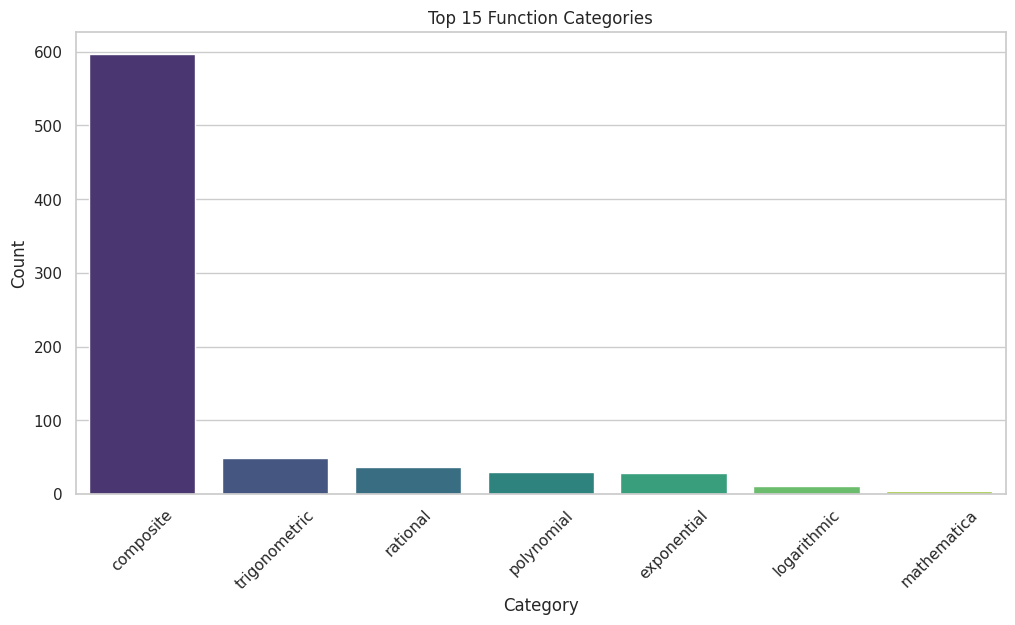

In [10]:
from collections import Counter

# Counting category frequencies
category_counts = Counter(categories)
top_categories = category_counts.most_common(15)  # Top 15 categories
top_categories_labels, top_categories_values = zip(*top_categories)

# Ploting top categories
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_categories_labels), y=list(top_categories_values), palette="viridis")
plt.title("Top 15 Function Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


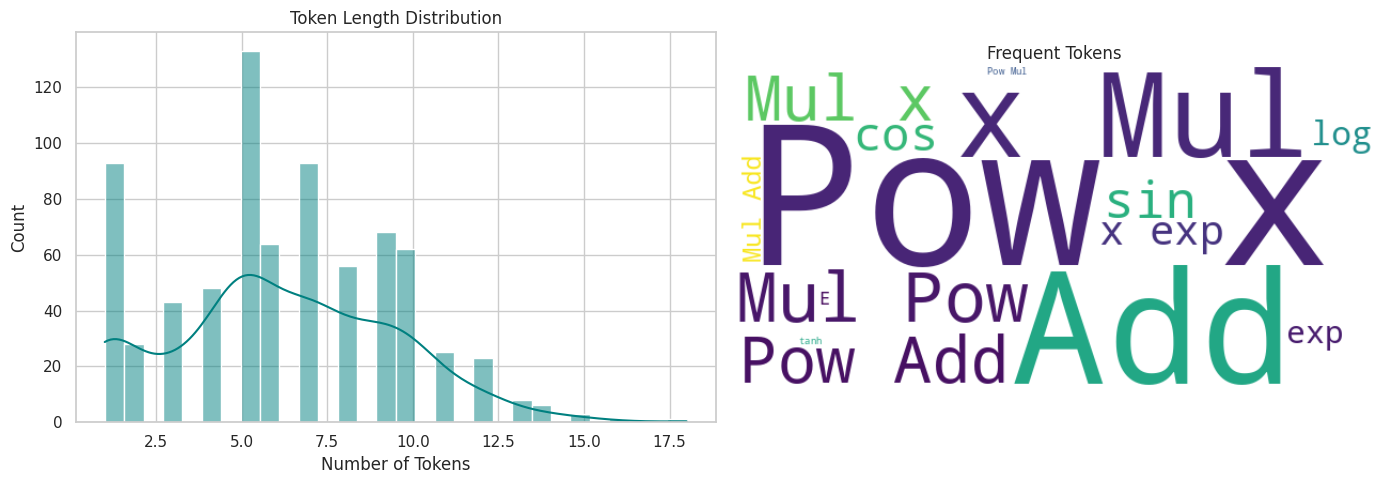

In [11]:
# Token analysis
all_tokens = [token for entry in dataset for token in entry['tokens']]
token_counts = [len(entry['tokens']) for entry in dataset]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(token_counts, bins=30, kde=True, color='teal')
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(' '.join(all_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Tokens")
plt.tight_layout()
plt.show()

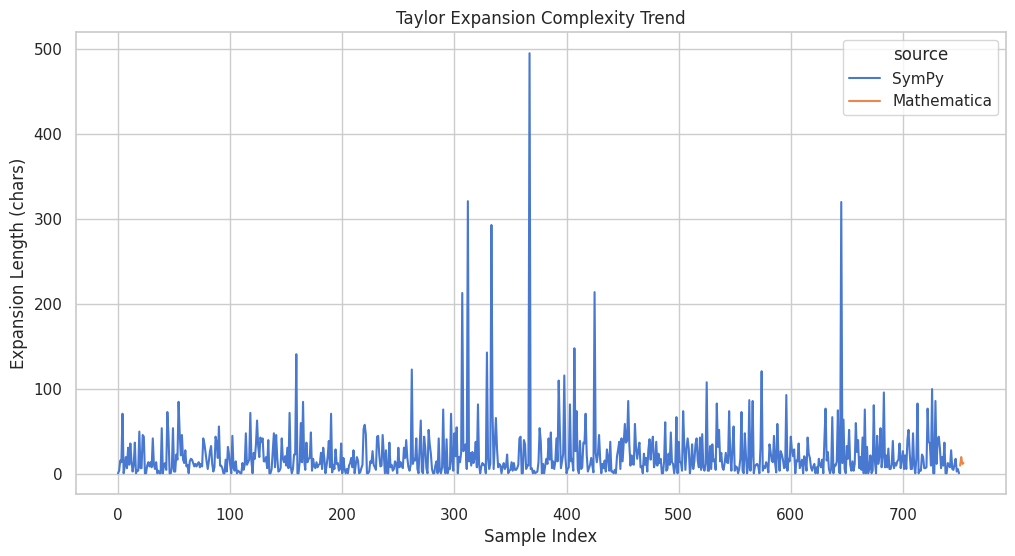

In [12]:
# Expansion complexity
df = pd.DataFrame(dataset)
df['expansion_length'] = df['expansion'].apply(len)

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=df.index,
    y='expansion_length',
    data=df,
    hue='source',
    estimator='median',
    errorbar=None
)
plt.title("Taylor Expansion Complexity Trend")
plt.xlabel("Sample Index")
plt.ylabel("Expansion Length (chars)")
plt.show()

Validating: 100%|██████████| 755/755 [00:02<00:00, 321.57it/s]
<ipython-input-13-48671b98539c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


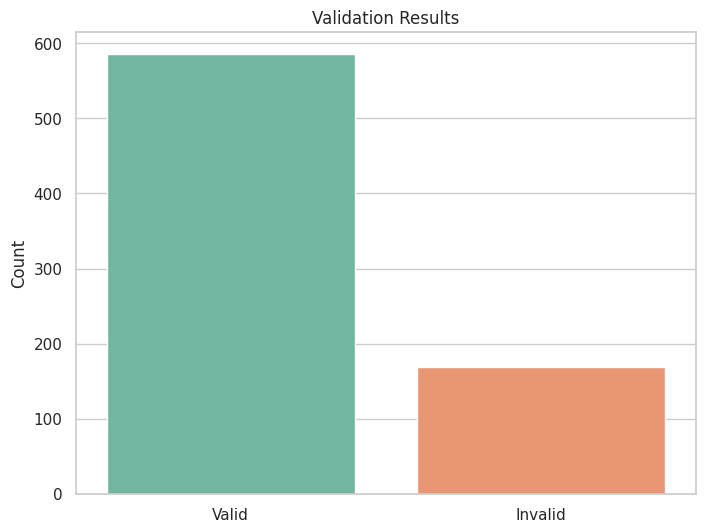

In [13]:
# Validation visualization
valid_counts = []
for entry in tqdm(dataset, desc="Validating"):
    try:
        x_val = 0.1
        func_val = sp.sympify(entry['function']).subs('x', x_val)
        exp_val = sp.sympify(entry['expansion']).subs('x', x_val)
        # Converting SymPy BooleanAtom to Python boolean
        is_valid = bool(abs(func_val - exp_val) < 1e-6)
        valid_counts.append(is_valid)
    except:
        valid_counts.append(False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=['Valid', 'Invalid'],
    y=[sum(valid_counts), len(valid_counts)-sum(valid_counts)],
    palette="Set2"
)
plt.title("Validation Results")
plt.ylabel("Count")
plt.show()

# Create valid_df based on validation results
# This creates a new DataFrame containing only the valid entries from 'dataset'
valid_df = pd.DataFrame(dataset)[valid_counts]
valid_df = valid_df.reset_index(drop=True) # Reset index for the new DataFrame

# 5. Final Export


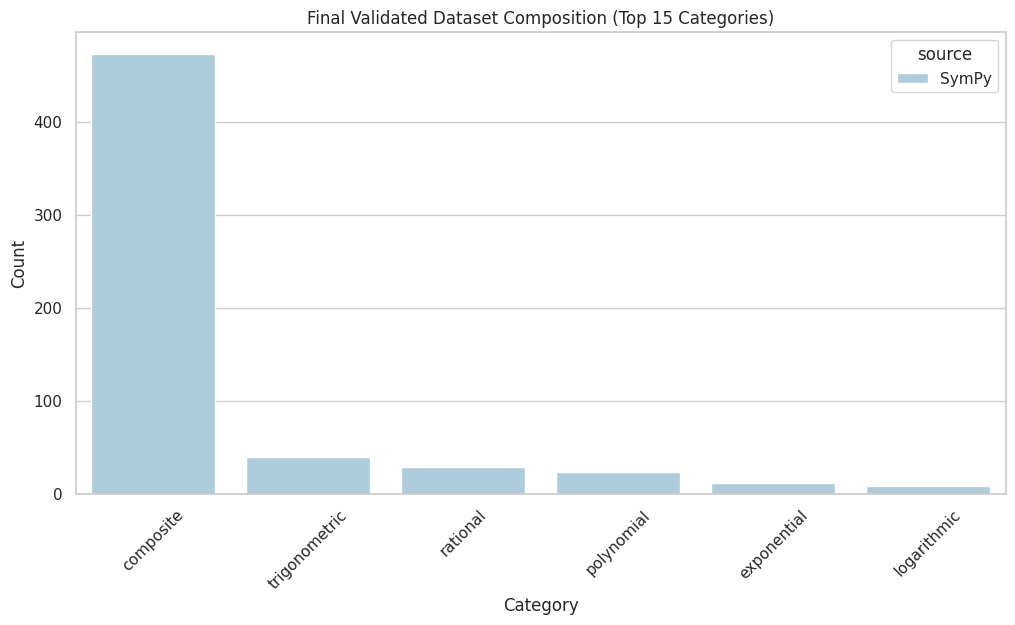

Final dataset saved with 586 valid entries (Top 15 categories)


In [14]:
# Counting frequencies of validated categories
valid_category_counts = Counter(valid_df['category'])
top_valid_categories = valid_category_counts.most_common(15)  # Top 15 validated categories
top_valid_labels, top_valid_values = zip(*top_valid_categories)

# Filtering valid_df to include only top 15 categories
valid_df_top = valid_df[valid_df['category'].isin(top_valid_labels)]

# Ploting top validated categories
plt.figure(figsize=(12, 6))
sns.countplot(
    x='category',
    data=valid_df_top,
    hue='source',
    palette="Paired",
    order=list(top_valid_labels)
)
plt.title("Final Validated Dataset Composition (Top 15 Categories)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Saveing the filtered dataset to CSV
valid_df_top.to_csv('symbolic_dataset_top_15.csv', index=False)
print(f"Final dataset saved with {len(valid_df_top)} valid entries (Top 15 categories)")
